In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='4'

## Da fare
1. Car model classification:
   - entire car images vs **car parts**
   - specific viewpoint vs all viewpoints
2. **Car make classification**
3. **Attribute Prediction:**
   - Sum of square loss for continuous attributes
   - Logistic loss for for discrete attributes
   - Trained of the first set and tested on the second 

In [2]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import random
import importlib
from pathlib import Path
import re

from torch.utils.data import Dataset, DataLoader
from torch.nn import Module, Sequential, Conv2d, BatchNorm2d
from torch.nn import SiLU as ReLU
from torch.optim import SGD, Adam
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss
from torchvision.transforms import Compose, ToTensor, RandomAffine, RandomHorizontalFlip, RandomVerticalFlip, ColorJitter, Resize
import torch

from dataset import *
from utils import *
from ResNet18_blocks import *
from ResNet50_blocks import *
from training_functions import *

seed = 0
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)

In [3]:
# import utils
# import dataset 
# import ResNet50_blocks 
# import ResNet18_blocks
# importlib.reload(utils)
# importlib.reload(dataset)
# importlib.reload(ResNet18_blocks)
# importlib.reload(ResNet50_blocks);

# Neural Network and Deep Learning Project

*Alberto Salvador, Volpi Gaia*



In [4]:
#volume_dir = "/mnt/shared_volume/"
volume_dir = "/mnt/home/u0053/disk/gaia_dataset/CompCars/"

In [5]:
# create folder inside volume dir 
for vp in range(6):
    if not os.path.exists(volume_dir + f'{vp}/'):
        os.makedirs(volume_dir + f'{vp}/')

In [6]:
! ls /mnt/shared_volume/data/train_test_split/classification

ls: cannot access '/mnt/shared_volume/data/train_test_split/classification': No such file or directory


## 1. Dataset

Qui sotto si crea il dataset per fare il training su tutti i viewpoints!!

In [7]:
label_to_index = indexing_labels(volume_dir+"data/train_test_split/classification/train.txt")
print("Nr of models in the train dataset: ", len(label_to_index))

Nr of models in the train dataset:  431


In [8]:
transforms_train = Compose([
    Resize((224, 224)), 
    ToTensor(), #this converts numpy or Pil image to torch tensor and normalizes it in 0, 1
    RandomAffine((0.05, 0.05)),
    RandomHorizontalFlip(),
    RandomVerticalFlip()
])

transforms = Compose([
    Resize((224, 224)),
    ToTensor()
])

In [9]:
label_type = 'model_id' # 'model_id' or 'make_id'
make_dataset = dataset_factory(volume_dir, label_to_index, transforms_train, transforms, label_type=label_type) # serve per creare la factory che genera i dataset

In [27]:
VIEWPOINT = None
train_dataset, test_dataset, valid_dataset =  make_dataset(VIEWPOINT) # carino perchè devi passare solo il viewpoint

IndexError: list index out of range

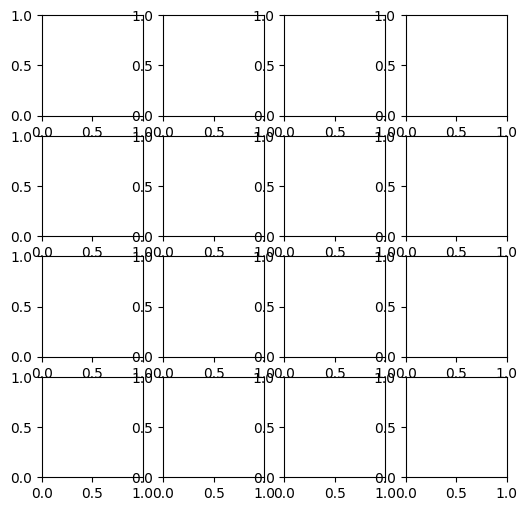

In [ ]:
fig, axs = plt.subplots(4, 4, figsize=(6,6))
for i in range(16):
    axs[i//4][i%4].imshow(train_dataset[i][0].permute(1, 2, 0).numpy())
    axs[i//4][i%4].set_xticks([])
    axs[i//4][i%4].set_yticks([])
    axs[i//4][i%4].set_title(f"{train_dataset[i][1]}")
plt.tight_layout()

In [28]:
print(f'train dataset: {len(train_dataset)} \ntest dataset: {len(test_dataset)} \nvalid dataset: {len(valid_dataset)}')

train dataset: 16016 
test dataset: 7576 
valid dataset: 7363


In [29]:
for VIEWPOINT in [None,1,2,3,4,5]:
    print(f"VIEWPOINT: {VIEWPOINT}")
    train_dataset, test_dataset, valid_dataset =  make_dataset(VIEWPOINT) # carino perchè devi passare solo il viewpoint
    print(f'\ttrain dataset: {len(train_dataset)} \ttest dataset: {len(test_dataset)} \tvalid dataset: {len(valid_dataset)}')


VIEWPOINT: None
	train dataset: 16016 	test dataset: 7576 	valid dataset: 7363
VIEWPOINT: 1
	train dataset: 2593 	test dataset: 0 	valid dataset: 2381
VIEWPOINT: 2
	train dataset: 1997 	test dataset: 0 	valid dataset: 1794
VIEWPOINT: 3
	train dataset: 2973 	test dataset: 177 	valid dataset: 2572
VIEWPOINT: 4
	train dataset: 4828 	test dataset: 3990 	valid dataset: 616
VIEWPOINT: 5
	train dataset: 3625 	test dataset: 3409 	valid dataset: 0


In [13]:
# Here we use the Dataloader function from pytorch to opportunely split the dataset in batches and shuffling data
batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=os.cpu_count())
valid_dataloader = DataLoader(valid_dataset, os.cpu_count()*2, shuffle=False, num_workers=os.cpu_count())
test_dataloader = DataLoader(test_dataset, os.cpu_count()*2, shuffle=False, num_workers=os.cpu_count())

In [14]:
#class weights
# labels_array = []
# for batch in train_dataloader:
#     _, labels = batch
#     labels_array.append(labels)
# labels_array = torch.cat(labels_array).numpy().astype(int)
# class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels_array), y=labels_array)

In [15]:
#check_unbalance_dataset(valid_dataloader, n_indices=3000, title='validation set')

In [16]:
#check_unbalance_dataset(train_dataloader, n_indices=3000, title='training set')

In [17]:
#check_unbalance_dataset(valid_dataloader, n_indices=3000, title='valid set')

## 2. Training 

We have implemented two different architectures:
- ResNet50
- ResNet 18

We will proceed with ResNet18 now!

In [18]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = ResNet18()
loss = CrossEntropyLoss
epochs = 200

#optimizer = Adam(params=model.parameters(), lr=3e-4, weight_decay=5e-4)

### 2.1 Training on all viewpoints
when: vp=None or '0'

In [13]:
#weight_decays = [1e-5, 1e-4, 5e-4]
wd = 1e-4
train_loss_log, val_loss_log, _ = network_training(
train_dataloader=train_dataloader, 
valid_dataloader=valid_dataloader,
load_checkpoint=load_checkpoint(
    load=False, 
    model=model,
    opt=Adam(params=model.parameters(), lr=3e-4, weight_decay=wd), 
    device=device, 
    volume_dir=volume_dir
),
loss_fn=fix_losses(calcul_class_weights(train_dataloader), CrossEntropyLoss, device),
device=device,
epochs=epochs,
save_checkpoint=lambda model, opt: save_checkpoint(model, opt, VIEWPOINT or "0", volume_dir),
save_metric=lambda metric, values: store_metric(volume_dir)(metric, values, VIEWPOINT)
)

fig, ax = plot_losses(train_loss_log, val_loss_log, save=True)
ax.set_title(f"weight_decay={wd}")
plt.savefig(volume_dir + "gridsearch/"+f"losses_wd{wd}.png")

Epoch: 1


Train loss: 6.2494 - Acc: 0.2:   7%|▋         | 17/251 [00:06<01:32,  2.53it/s]


KeyboardInterrupt: 

In [12]:
torch.save(model.state_dict(), volume_dir+'0'+"/model_1.pt") 

In [ ]:
train_loss_log = np.loadtxt(volume_dir+str(VIEWPOINT or '0')+'/train_loss_log.txt').tolist()
val_loss_log = np.loadtxt(volume_dir+str(VIEWPOINT or '0')+'/val_loss_log.txt').tolist()
plot_losses(train_loss_log, val_loss_log)

### 2.1 Training on different viewpoints (label_type='model_id')

In [ ]:
label_type = 'model_id' # 'model_id' or 'make_id'

optimizer = Adam(params=model.parameters(), lr=3e-4, weight_decay=0.0001)


metrics = multi_viewpoint_training(
    viewpoints=[5], 
    epochs=epochs, 
    make_dataset=make_dataset,
    load_checkpoint=load_checkpoint(
        load=False, 
        model=model,
        opt=optimizer, 
        device=device, 
        volume_dir=volume_dir
    ), 
    loss_fn=lambda class_weights: fix_losses(class_weights, loss, device), 
    device=device, 
    save_checkpoint=lambda model, opt, viewpoint: save_checkpoint(model, opt, viewpoint or "0", volume_dir), 
    load_pretrain=lambda device, model, vp :load_pretrain(volume_dir, device, model, None, vp=vp),
    save_metric=store_metric(volume_dir), 
    model_class=type(model), 
    k_list=[1,5], 
    label_type=label_type
)

Epoch: 1


Train loss: 5.9677 - Acc: 0.3: 100%|██████████| 76/76 [00:14<00:00,  5.39it/s]


Starting validation...
valid_dataloader  616


  0%|          | 0/4 [00:00<?, ?it/s]Exception ignored in: <function _releaseLock at 0x7fcce9111b40>
Traceback (most recent call last):
  File "/mnt/home/u0053/.conda/envs/alberto/lib/python3.10/logging/__init__.py", line 228, in _releaseLock
    def _releaseLock():
KeyboardInterrupt: 
  0%|          | 0/4 [00:07<?, ?it/s]


RuntimeError: DataLoader worker (pid(s) 278390, 278391, 278392, 278393, 278394, 278395, 278396, 278397, 278398, 278399, 278400, 278401, 278402, 278403, 278404, 278405, 278406, 278407, 278408, 278409, 278410, 278411, 278412, 278413, 278414, 278415, 278416, 278417, 278418, 278419, 278420, 278421, 278422, 278423, 278424, 278425, 278426, 278427, 278428, 278429, 278430, 278431, 278432, 278433, 278434, 278435, 278436, 278437, 278438, 278439, 278440, 278441, 278442, 278443, 278444, 278445, 278446, 278447, 278448, 278449, 278451) exited unexpectedly

### 2.1 Training on different viewpoints (label_type='make_id')

In [ ]:
label_type = 'make_id' # 'model_id' or 'make_id'

optimizer = Adam(params=model.parameters(), lr=3e-4, weight_decay=0.0001)

metrics = multi_viewpoint_training(
    viewpoints=[5], 
    epochs=epochs, 
    make_dataset=make_dataset,
    load_checkpoint=load_checkpoint(
        load=False, 
        model=model,
        opt=optimizer, 
        device=device, 
        volume_dir=volume_dir
    ), 
    loss_fn=lambda class_weights: fix_losses(class_weights, loss, device), 
    device=device, 
    save_checkpoint=lambda model, opt, viewpoint: save_checkpoint(model, opt, viewpoint or "0", volume_dir), 
    load_pretrain=lambda device, model, vp :load_pretrain(volume_dir, device, model, None, vp=vp),
    save_metric=store_metric(volume_dir), 
    model_class=type(model), 
    k_list=[1,5], 
    label_type=label_type
)

print the table with all results

In [ ]:
tab3 = table3(folder_path=volume_dir + 'table3/')
tab3